In [ ]:
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
np.choose()

In [2]:
import numpy as np

matrix       = np.random.normal(size=(3, 4))
keep_prop    = .1

matrix

array([[ 0.2872929 , -0.33250188,  1.24970416,  0.50716024],
       [-0.23038435, -0.60172915,  0.64913927, -0.03428253],
       [ 0.54758092, -0.33339493,  1.10944172,  0.37977258]])

In [4]:
dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
dropout_mask

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

In [5]:
pad_ix = 2
dropout_mask &= matrix != pad_ix
dropout_mask

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import time
import math

from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec

SEED = 41
np.random.seed(SEED)

In [2]:
RAW_DATA_PATH        = '../../dl_nlp/data/jigsaw_toxic/raw/'
PROCESSED_DATA_PATH  = '../../dl_nlp/data/jigsaw_toxic/processed/' 

MAX_LEN = 100

### Load Data

In [3]:
%%time

train       = pd.read_csv(os.path.join(RAW_DATA_PATH, 'train.csv'))
test        = pd.read_csv(os.path.join(RAW_DATA_PATH, 'test.csv'))
test_labels = pd.read_csv(os.path.join(RAW_DATA_PATH, 'test_labels.csv'))

CPU times: user 1.46 s, sys: 252 ms, total: 1.71 s
Wall time: 2.35 s


#### Define target columns

In [4]:
TARGET_COLS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#### Load Sample

In [5]:
# train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'train_sample.csv'))

#### Process dataset 

In [5]:
train['decent'] = 1 - train.loc[:, TARGET_COLS].max(axis=1)
TARGET_COLS     += ['decent']

#### Preprocessing

In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [9]:
%%time
train_tokenized_comments = list(map(tokenizer.tokenize, train.comment_text))

CPU times: user 4.66 s, sys: 368 ms, total: 5.02 s
Wall time: 5.02 s


In [7]:
%%time
train['tokenized_comments'] = list(map(' '.join, map(tokenizer.tokenize, train.comment_text)))
test['tokenized_comments']  = list(map(' '.join, map(tokenizer.tokenize, test.comment_text)))

CPU times: user 7.99 s, sys: 108 ms, total: 8.1 s
Wall time: 8.1 s


#### Define Word2Vec model

In [10]:
%%time

model = Word2Vec(train_tokenized_comments, 
                 size=32,      
                 min_count=10,  
                 window=5).wv

In [11]:
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)

#### Load pretrained embeddings

In [12]:
word_vectors = model.vectors[[model.vocab[word].index for word in words]]

In [13]:
emb_mean,emb_std = word_vectors.mean(), word_vectors.std()
emb_mean,emb_std

(0.019592637, 0.720103)

In [14]:
UNK, PAD       = 'UNK', 'PAD'
UNK_IX, PAD_IX = len(words), len(words) + 1

nb_words   = len(words) + 2
embed_size = 32

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word in words + [UNK, PAD]:
    if word in model.vocab:
        word_idx         = model.vocab[word].index
        embedding_vector = model.vectors[model.vocab[word].index]
        embedding_matrix[word_idx] = embedding_vector

In [15]:
token_to_id      = {word: model.vocab[word].index for word in words}

token_to_id[UNK] = UNK_IX
token_to_id[PAD] = PAD_IX

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(train, test_size=0.2, random_state=42)
data_train.index     = range(len(data_train))
data_val.index       = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  127656
Validation size =  31915


In [18]:
def iterate_batches(matrix, labels, batch_size, predict_mode='train'):
    indices = np.arange(len(matrix))
    if predict_mode == 'train':
        np.random.shuffle(indices)
    
    for start in range(0, len(matrix), batch_size):
        end = min(start + batch_size, len(matrix))
        
        batch_indices = indices[start: end]
        X = matrix[batch_indices]
        
        if predict_mode != 'train': yield X
        else: yield X, labels[batch_indices]

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
class TConvolution(nn.Module):
    def __init__(self, pre_trained_embeddings, vocab_size, hidden_dim, num_classes, PAD_IX):
        super(TConvolution, self).__init__()
        
        self.hidden_dim  = hidden_dim
        self.vocab_size  = vocab_size
        self.num_classes = num_classes 
        
        self.Cin         = 1
        self.Cout        = 1
        
        self.embedding        = nn.Embedding(self.vocab_size, self.hidden_dim, padding_idx=PAD_IX)
        self.embedding.weight = nn.Parameter(pre_trained_embeddings)
        
        self.conv_layer1 = nn.Conv2d(self.Cout, self.Cin, kernel_size=(3, self.hidden_dim))
        self.conv_layer2 = nn.Conv2d(self.Cout, self.Cin, kernel_size=(4, self.hidden_dim))
    
        self.relu        = nn.ReLU()
        self.fc          = nn.Linear(2, self.num_classes)
        
    def forward(self, x):
        emb = self.embedding(x)
        # create a matrix of shape ( N, Cin, max_len, embedding_dim)
        emb = emb.unsqueeze(1)
        
        # pass it through convolutional layer to calculate unigrams
        out1 = self.conv_layer1(emb)
        out1 = self.relu(out1)
        out1 = out1.squeeze(3)
        
        out2  = self.conv_layer2(emb)
        out2  = self.relu(out2)
        out2  = out2.squeeze(3)
                
        # global max pool
        out1, _ = torch.max(out1, dim=-1)
        out2, _ = torch.max(out2, dim=-1)
        
        out     = torch.cat((out1, out2), dim=1)
        
        # fully connected layer
        out     = self.fc(out)
        
        return out

In [24]:
def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, total_size = 0, 0
    per_label_preds = [[], [], [], [], [], [], []]
    per_label_true  = [[], [], [], [], [], [], []]
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = torch.cuda.LongTensor(X_batch), torch.cuda.FloatTensor(y_batch)

            logits = model(X_batch)
            loss   = criterion(logits, y_batch)
            
            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            # convert true target
            batch_target = y_batch.cpu().detach().numpy()
            logits_cpu   = logits.cpu().detach().numpy()
            
            # per_label_preds
            for j in range(7):
                label_preds     = logits_cpu[:, j]
                per_label_preds[j].extend(label_preds)
                per_label_true[j].extend(batch_target[:, j])
                            
            # calculate log loss
            epoch_loss += loss.item()

            print('\r[{} / {}]: Loss = {:.4f}'.format(
                  i, batchs_count, loss.item(), end=''))
    
    label_auc = []
    
    for i in range(7):
        label_auc.append(roc_auc_score(per_label_true[i], per_label_preds[i]))
    
    return epoch_loss / batchs_count, np.mean(label_auc)

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_auc = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Train AUC = {:.4f}'
        if not val_data is None:
            val_loss, val_auc   = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time   = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Val AUC = {:.4f}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss,
                                     train_auc,
                                     val_loss,
                                     val_auc
                                    ))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss, train_auc))

In [25]:
model        = TConvolution(pre_trained_embeddings=torch.FloatTensor(embedding_matrix), 
                         vocab_size=len(token_to_id), 
                         hidden_dim=embed_size, 
                         num_classes=7, 
                         PAD_IX=PAD_IX).cuda()

criterion    = nn.BCEWithLogitsLoss().cuda()
optimizer    = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.01)

X_train      = as_matrix(data_train['tokenized_comments'])
train_labels = data_train.loc[:, TARGET_COLS].values 

X_test       = as_matrix(data_val['tokenized_comments'])
test_labels  = data_val.loc[:, TARGET_COLS].values

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=5, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

[0 / 250]: Loss = 1.1208
[1 / 250]: Loss = 0.9380
[2 / 250]: Loss = 0.8857
[3 / 250]: Loss = 0.8513
[4 / 250]: Loss = 0.8371
[5 / 250]: Loss = 0.8250
[6 / 250]: Loss = 0.8151
[7 / 250]: Loss = 0.7983
[8 / 250]: Loss = 0.7690
[9 / 250]: Loss = 0.7553
[10 / 250]: Loss = 0.7382
[11 / 250]: Loss = 0.7189
[12 / 250]: Loss = 0.7056
[13 / 250]: Loss = 0.6877
[14 / 250]: Loss = 0.6687
[15 / 250]: Loss = 0.6531
[16 / 250]: Loss = 0.6309
[17 / 250]: Loss = 0.6153
[18 / 250]: Loss = 0.5973
[19 / 250]: Loss = 0.5785
[20 / 250]: Loss = 0.5619
[21 / 250]: Loss = 0.5437
[22 / 250]: Loss = 0.5261
[23 / 250]: Loss = 0.5111
[24 / 250]: Loss = 0.4973
[25 / 250]: Loss = 0.4823
[26 / 250]: Loss = 0.4640
[27 / 250]: Loss = 0.4453
[28 / 250]: Loss = 0.4389
[29 / 250]: Loss = 0.4261
[30 / 250]: Loss = 0.4017
[31 / 250]: Loss = 0.3888
[32 / 250]: Loss = 0.3732
[33 / 250]: Loss = 0.3622
[34 / 250]: Loss = 0.3458
[35 / 250]: Loss = 0.3512
[36 / 250]: Loss = 0.3208
[37 / 250]: Loss = 0.3161
[38 / 250]: Loss = 0.2

#### Token to count

In [86]:
from collections import Counter
token_counts = Counter()

In [87]:
%%time

for comment in train.tokenized_comments:
    token_counts.update(comment.split())

CPU times: user 2.58 s, sys: 24 ms, total: 2.61 s
Wall time: 2.61 s


In [88]:
token_counts.most_common(10)

[('.', 562731),
 (',', 453829),
 ('the', 449181),
 ('to', 291937),
 ('I', 224460),
 ('of', 220958),
 ('and', 212559),
 ('a', 203959),
 ("'", 199211),
 ('you', 182078)]

In [89]:
print('Total unique tokens: {}'.format(len(token_counts)))
print('\n'.join(map(str, token_counts.most_common(5))))
print()
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens: 240640
('.', 562731)
(',', 453829)
('the', 449181)
('to', 291937)
('I', 224460)

('Superlatives', 1)
('Classifying', 1)
('CIU', 1)


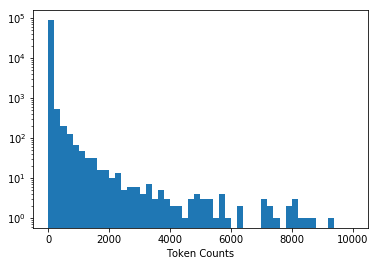

In [10]:
plt.hist(token_counts.values(), range=(0, 10 ** 4), log=True, bins=50)
plt.xlabel('Token Counts');

#### Remove rare words from the dictionary.

In [90]:
min_count = 10
tokens    = {token: count for token, count in token_counts.items() if count >= min_count}

In [91]:
UNK, PAD = 'UNK', 'PAD'
tokens   = [UNK, PAD] + sorted(tokens)
print('Vocabulary size:', len(tokens))

assert type(tokens) == list
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32840
Correct!


#### Mapping from token to id

In [92]:
%%time
token_to_id = dict(map(reversed, zip(range(len(tokens)), tokens)))

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 18.9 ms


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [1]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

NameError: name 'token_to_id' is not defined

In [15]:
print('Lines:')
print('\n'.join(train['tokenized_comments'][:2].values), end='\n\n')
print('Matrix:')
print(as_matrix(train['tokenized_comments'])[:2])

Lines:
Learning Hawaiian as a second language Stubby , no citations . If / when improved , it can be put back in the article . When trying to learn Hawaiian as a second language , without a competent teacher and without native speakers of Hawaiian as models , English - speaking learners might mispronounce Hawaiian words by using English values for the letters . Also , learners might not be aware that one cannot simply replace the English words in an English sentence with Hawaiian words as a way to create a Hawaiian sentence . Hawaiian and English have important differences in the order of words in a phrase , and the order of phrases in a sentence . Reviving Hawaiian as a first language Stubby , no citations . If / when improved , it can be put back in the article . There is a certain tension between those who would revive a purist Hawaiian , as spoken in the early 19th century , and those who grew up speaking a colloquial Hawaiian shaped by more than one hundred years of contact with E

### Split into training and test set

In [15]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(train, test_size=0.2, random_state=42)
data_train.index     = range(len(data_train))
data_val.index       = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  25531
Validation size =  6383


### Create Batches

```
[[1, 2, 3, 4],
 [4, 1, 4, 1],
 ....
] -> [[0, 1, 1], [1, 1, 0]]
```

In [94]:
def iterate_batches(matrix, labels, batch_size, predict_mode='train'):
    indices = np.arange(len(matrix))
    if predict_mode == 'train':
        np.random.shuffle(indices)
    
    for start in range(0, len(matrix), batch_size):
        end = min(start + batch_size, len(matrix))
        
        batch_indices = indices[start: end]
        X = matrix[batch_indices]
        
        if predict_mode != 'train': yield X
        else: yield X, labels[batch_indices] 

In [14]:
matrix = as_matrix(data_train['tokenized_comments'], max_len=MAX_LEN)
labels = data_train.loc[:, TARGET_COLS].values

X, y   = next(iterate_batches(matrix, labels, batch_size=2))

### Model

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [96]:
class TConvolution(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes, PAD_IX):
        super(TConvolution, self).__init__()
        
        self.hidden_dim  = hidden_dim
        self.vocab_size  = vocab_size
        self.num_classes = num_classes 
        
        self.Cin         = 1
        self.Cout        = 1
        
        self.embedding   = nn.Embedding(self.vocab_size, self.hidden_dim, padding_idx=PAD_IX)
        self.conv_layer1 = nn.Conv2d(self.Cout, self.Cin, kernel_size=(1, self.hidden_dim))
        self.conv_layer2 = nn.Conv2d(self.Cout, self.Cin, kernel_size=(2, self.hidden_dim))
        self.relu        = nn.ReLU()
        self.fc          = nn.Linear(2, self.num_classes)
        
    def forward(self, x):
        emb = self.embedding(x)
        # create a matrix of shape ( N, Cin, max_len, embedding_dim)
        emb = emb.unsqueeze(1)
        
        # pass it through convolutional layer to calculate unigrams
        out1 = self.conv_layer1(emb)
        out1 = self.relu(out1)
        out1 = out1.squeeze(3)
        
        out2  = self.conv_layer2(emb)
        out2  = self.relu(out2)
        out2  = out2.squeeze(3)
                
        # global max pool
        out1, _ = torch.max(out1, dim=-1)
        out2, _ = torch.max(out2, dim=-1)
        
        out     = torch.cat((out1, out2), dim=1)
        
        # fully connected layer
        out     = self.fc(out)
        
        return out

In [17]:
model     = TConvolution(len(token_to_id), hidden_dim=32, num_classes=7, PAD_IX=PAD_IX).cuda()
criterion = nn.BCEWithLogitsLoss().cuda()

### Run on a single batch

In [25]:
X      = torch.cuda.LongTensor(X)
y      = torch.cuda.FloatTensor(y)

logits = model(X)

In [26]:
loss = criterion(logits, y)
loss.item()

1.1132473945617676

### Training Loop

```
Evaluation:

Mean columnwise auc score: In other words, the score is the average of the individual AUCs of each predicted column.

example:
  
TRUE: 
  a  b  c
[[1, 0, 1],
 [0, 1, 0],
 [0, 0, 1],
 [0, 1, 1]
]

PREDS:
  a    b    c
[[0.3, 0.6, 0.1],
 [0.1, 0.1, 0.8],
 [0.2, 0.2, 0.6]
]

AUC score for column (a) : auc_a = roc_auc_score(true_a, preds_a)
AUC score for column (b) : auc_b = roc_auc_score(true_b, preds_b)
AUC score for column (c) : auc_c = roc_auc_score(true_c, preds_c)

Mean score = (auc_a + auc_b + auc_c) / 3


Required:

true matrix = one hot encoded data frame of target labels

```

In [48]:
def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, total_size = 0, 0
    per_label_preds = [[], [], [], [], [], [], []]
    per_label_true  = [[], [], [], [], [], [], []]
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = torch.cuda.LongTensor(X_batch), torch.cuda.FloatTensor(y_batch)

            logits = model(X_batch)
            loss   = criterion(logits, y_batch)
            
            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            # convert true target
            batch_target = y_batch.cpu().detach().numpy()
            logits_cpu   = logits.cpu().detach().numpy()
            
            # per_label_preds
            for j in range(7):
                label_preds     = logits_cpu[:, j]
                per_label_preds[j].extend(label_preds)
                per_label_true[j].extend(batch_target[:, j])
                            
            # calculate log loss
            epoch_loss += loss.item()

            print('\r[{} / {}]: Loss = {:.4f}'.format(
                  i, batchs_count, loss.item(), end=''))
    
    label_auc = []
    
    for i in range(7):
        label_auc.append(roc_auc_score(per_label_true[i], per_label_preds[i]))
    
    return epoch_loss / batchs_count, np.mean(label_auc)

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_auc = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Train AUC = {:.4f}'
        if not val_data is None:
            val_loss, val_auc   = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time   = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Val AUC = {:.4f}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss,
                                     train_auc,
                                     val_loss,
                                     val_auc
                                    ))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss, train_auc))

In [22]:
model        = TConvolution(len(token_to_id), hidden_dim=64, num_classes=7).cuda()
criterion    = nn.BCEWithLogitsLoss().cuda()
optimizer    = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.01)

X_train      = as_matrix(data_train['tokenized_comments'])
train_labels = data_train.loc[:, TARGET_COLS].values 

X_test       = as_matrix(data_val['tokenized_comments'])
test_labels  = data_val.loc[:, TARGET_COLS].values

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=5, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

[0 / 250]: Loss = 0.9652
[1 / 250]: Loss = 0.9023
[2 / 250]: Loss = 0.8616
[3 / 250]: Loss = 0.8374
[4 / 250]: Loss = 0.8124
[5 / 250]: Loss = 0.7890
[6 / 250]: Loss = 0.7742
[7 / 250]: Loss = 0.7613
[8 / 250]: Loss = 0.7493
[9 / 250]: Loss = 0.7399
[10 / 250]: Loss = 0.7277
[11 / 250]: Loss = 0.7209
[12 / 250]: Loss = 0.7138
[13 / 250]: Loss = 0.7092
[14 / 250]: Loss = 0.7005
[15 / 250]: Loss = 0.6939
[16 / 250]: Loss = 0.6871
[17 / 250]: Loss = 0.6789
[18 / 250]: Loss = 0.6728
[19 / 250]: Loss = 0.6651
[20 / 250]: Loss = 0.6565
[21 / 250]: Loss = 0.6488
[22 / 250]: Loss = 0.6372
[23 / 250]: Loss = 0.6259
[24 / 250]: Loss = 0.6150
[25 / 250]: Loss = 0.6047
[26 / 250]: Loss = 0.5897
[27 / 250]: Loss = 0.5767
[28 / 250]: Loss = 0.5618
[29 / 250]: Loss = 0.5485
[30 / 250]: Loss = 0.5349
[31 / 250]: Loss = 0.5149
[32 / 250]: Loss = 0.5007
[33 / 250]: Loss = 0.4847
[34 / 250]: Loss = 0.4664
[35 / 250]: Loss = 0.4524
[36 / 250]: Loss = 0.4324
[37 / 250]: Loss = 0.4208
[38 / 250]: Loss = 0.3

### Full Training

```
Full Training

a) Train model for 3 epochs using our Convolutional Model.
b) Store all the hyper-parameters used for the experiment.
c) Store model to disk using Pytorch best practices.
d) Load model from disk in the prediction phase ( full test set )
e) Write a method that takes in model and the test dataset and returns back all the predictions in the same
   order.
f) Generate logits for every label ( we would generate logits for all the 7 labels but we need sigmoid
   for only 6 labels ).
g) Apply sigmoid across all rows for all the 6 not 7 labels.
h) Using Kaggle API, submit predictions to kaggle and note down the public and private evaluation score.
```

In [97]:
def predict(model, data, batch_size):
    is_train = False
    model.train(is_train)
    
    batchs_count = math.ceil(data.shape[0] / batch_size)
    preds        = []
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, X_batch in enumerate(iterate_batches(data, labels=[], batch_size=batch_size, predict_mode='test')):
            X_batch = torch.cuda.LongTensor(X_batch)
            logits  = model(X_batch)
            p       = torch.sigmoid(logits).cpu().detach().numpy()
            
            preds.append(p)
    
    return np.vstack(preds)

In [98]:
model        = TConvolution(len(token_to_id), hidden_dim=64, num_classes=7, PAD_IX=PAD_IX).cuda()
criterion    = nn.BCEWithLogitsLoss().cuda()
optimizer    = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.01)

X_train      = as_matrix(train['tokenized_comments'])
train_labels = train.loc[:, TARGET_COLS].values

# train model
fit(model, 
    criterion, 
    optimizer, 
    train_data=(X_train, train_labels), 
    epochs_count=3, 
    batch_size=512)

[0 / 312]: Loss = 0.9834
[1 / 312]: Loss = 0.8984
[2 / 312]: Loss = 0.8541
[3 / 312]: Loss = 0.8202
[4 / 312]: Loss = 0.7915
[5 / 312]: Loss = 0.7702
[6 / 312]: Loss = 0.7529
[7 / 312]: Loss = 0.7377
[8 / 312]: Loss = 0.7260
[9 / 312]: Loss = 0.7161
[10 / 312]: Loss = 0.7075
[11 / 312]: Loss = 0.6983
[12 / 312]: Loss = 0.6914
[13 / 312]: Loss = 0.6839
[14 / 312]: Loss = 0.6769
[15 / 312]: Loss = 0.6702
[16 / 312]: Loss = 0.6587
[17 / 312]: Loss = 0.6497
[18 / 312]: Loss = 0.6413
[19 / 312]: Loss = 0.6313
[20 / 312]: Loss = 0.6199
[21 / 312]: Loss = 0.6081
[22 / 312]: Loss = 0.5976
[23 / 312]: Loss = 0.5861
[24 / 312]: Loss = 0.5755
[25 / 312]: Loss = 0.5579
[26 / 312]: Loss = 0.5468
[27 / 312]: Loss = 0.5372
[28 / 312]: Loss = 0.5193
[29 / 312]: Loss = 0.4926
[30 / 312]: Loss = 0.4867
[31 / 312]: Loss = 0.4672
[32 / 312]: Loss = 0.4685
[33 / 312]: Loss = 0.4414
[34 / 312]: Loss = 0.4333
[35 / 312]: Loss = 0.4315
[36 / 312]: Loss = 0.4149
[37 / 312]: Loss = 0.3900
[38 / 312]: Loss = 0.3

In [99]:
# generate Xtest matrix
X_test = as_matrix(test['tokenized_comments'])
preds  = predict(model, X_test, batch_size=512)
# create generator for test set

In [100]:
preds.shape

(153164, 7)

In [102]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,decent,tokenized_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,D ' aww ! He matches this background colour I ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,"Hey man , I ' m really not trying to edit war ..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,""" More I can ' t make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,"You , sir , are my hero . Any chance you remem..."


In [106]:
test_labels.iloc[:, 1:] = preds[:, :-1]

In [108]:
test_labels.to_csv('./conv1d_sub.csv', index=False)

In [ ]:
!/home/jupyter/.local/bin/kaggle competitions submit jigsaw-toxic-comment-classification-challenge -f ./conv1.csv -m 'Baseline sub'